Wayne Polatkan

---

20190715 | ~1446~1616 | [fastai DL1v3 L1 (review) homework](https://course.fast.ai/videos/?lesson=1)

Result: 91.667% accuracy; trained on 147 imgs for 2 classes; tested on 36.

In [1]:
from fastai.vision import *
from fastai.datasets import *

### create directory

get where the data path for fastai is

In [2]:
path = Config.data_path()

make the base data folder

In [11]:
paths = [path/'raptors',path/'raptors/falcon',path/'raptors/hawk']
for datapath in paths: datapath.mkdir(parents=True, exist_ok=True)

check that it's there

In [12]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/raptors'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet.tgz'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet')]

In [13]:
(path/'raptors').ls()

[PosixPath('/home/jupyter/.fastai/data/raptors/falcon'),
 PosixPath('/home/jupyter/.fastai/data/raptors/hawk')]

In [3]:
datapath = path/'raptors'

### download data

move urls files to data directory

In [15]:
!ls

Untitled.ipynb	urls_falcon.txt  urls_hawk.txt


In [17]:
!ls {datapath}

falcon	hawk


In [18]:
!mv urls_falcon.txt {datapath}/
!mv urls_hawk.txt {datapath}/

In [20]:
!ls {datapath}

falcon	hawk  urls_falcon.txt  urls_hawk.txt


download from urls

In [22]:
datapath.ls()

[PosixPath('/home/jupyter/.fastai/data/raptors/falcon'),
 PosixPath('/home/jupyter/.fastai/data/raptors/hawk'),
 PosixPath('/home/jupyter/.fastai/data/raptors/urls_hawk.txt'),
 PosixPath('/home/jupyter/.fastai/data/raptors/urls_falcon.txt')]

In [32]:
f.stem.split('_')[1]

'falcon'

In [53]:
for f in datapath.ls():
    if f.is_file and f.suffix == '.txt': 
        folder = f.stem.split('_')[1] # split '/home/jupyter/.fastai/data/raptors/urls_falcon.txt' --> 'falcon'
        print(f"{f} --> {folder}")
        download_images(datapath/f, datapath/folder, max_pics=200, max_workers=0)

In [54]:
for f in datapath.ls():
    if f.is_dir(): print(f"{f.stem}: {len(f.ls())}")

falcon: 100
hawk: 100


### verify images

In [55]:
classes = ['hawk','falcon']

In [56]:
for c in classes:
    print(c)
    verify_images(datapath/c, delete=True, max_size=500)

In [60]:
np.random.seed(0)
data = ImageDataBunch.from_folder(datapath, train=".", valid_pct=0.2,
                                  ds_tfms=get_transforms(), size=224
                                 ).normalize(imagenet_stats)

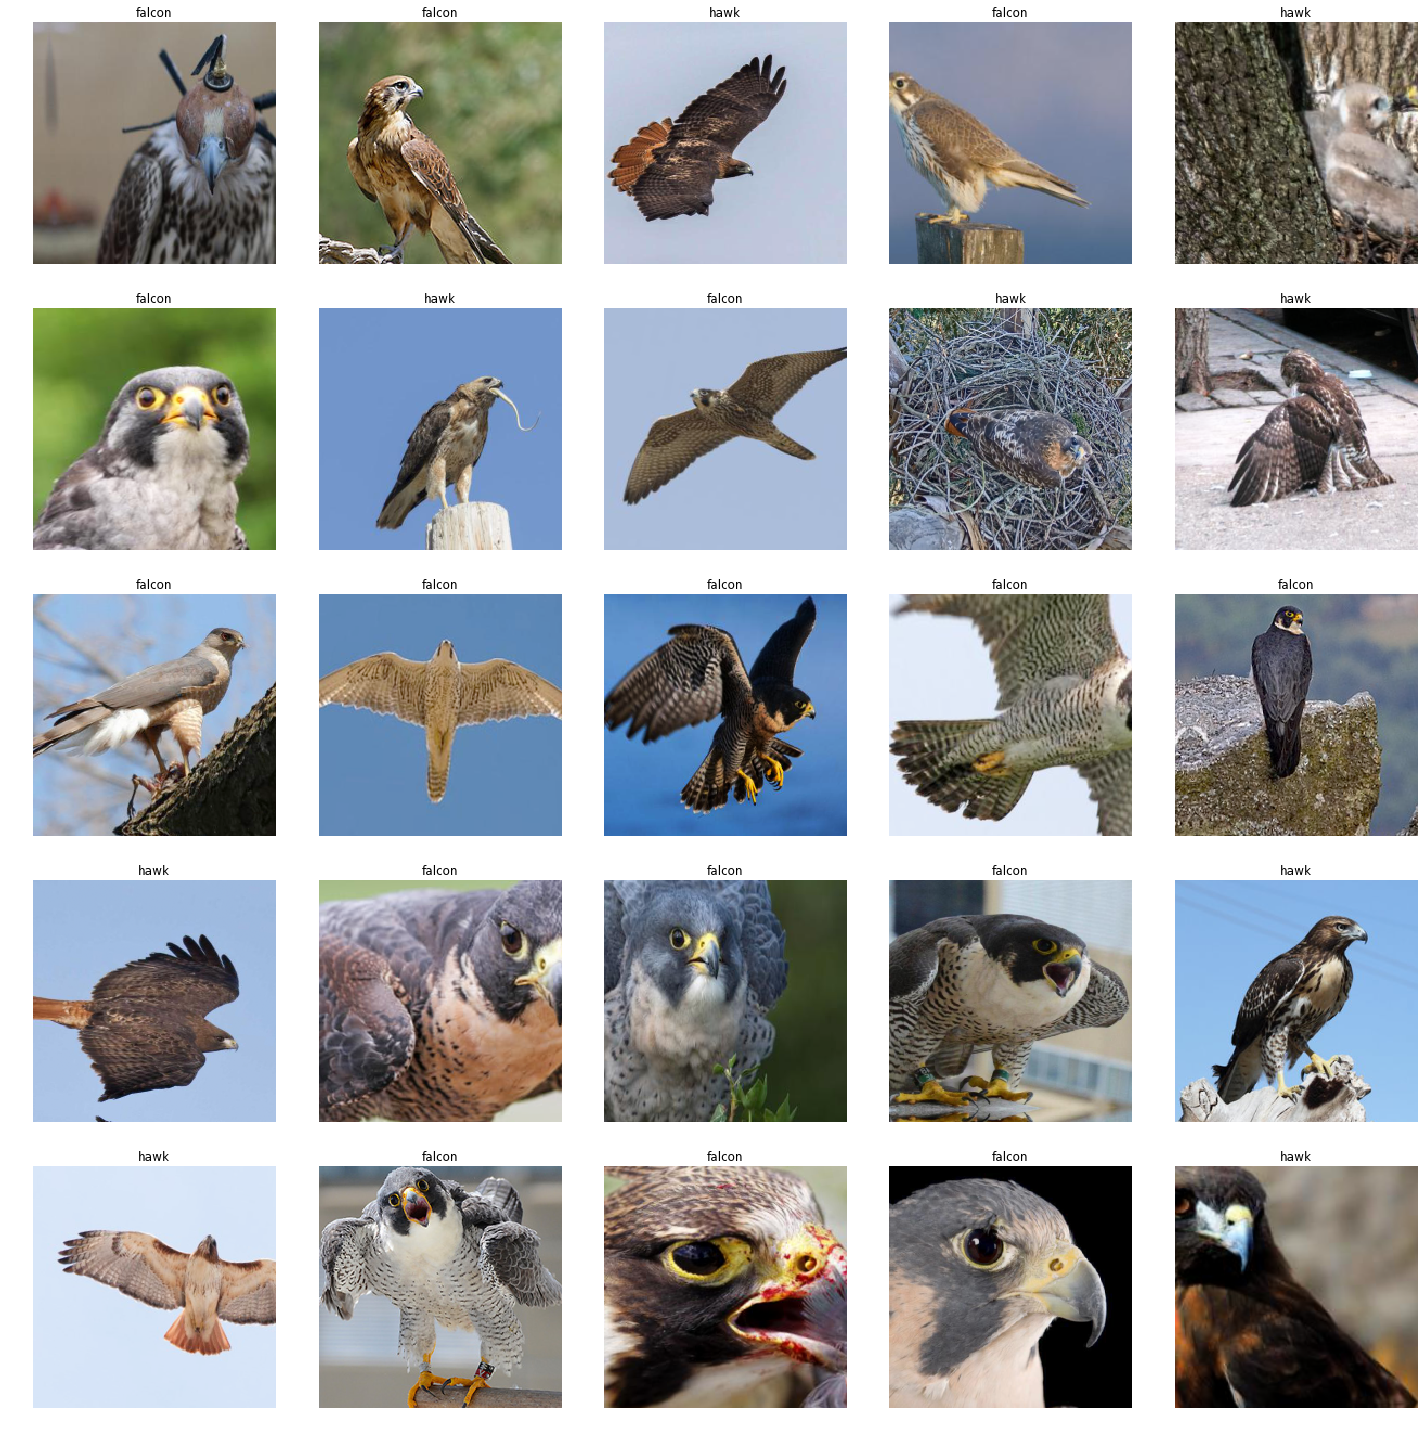

In [65]:
data.show_batch()

In [67]:
!ls ~/.fastai/data/raptors

falcon	hawk  urls_falcon.txt  urls_hawk.txt


In [72]:
!ls ~/.fastai/data/raptors/falcon

00000000.jpg   00000020.jpg  00000040.jpg  00000061.jpg  00000083.jpg
00000001.jpg   00000021.jpg  00000041.jpg  00000062.jpg  00000084.jpg
00000002.jpg   00000022.jpg  00000042.jpg  00000063.jpg  00000085.jpg
00000003.jpg   00000023.jpg  00000044.jpg  00000064.jpg  00000086.jpg
00000004.jpg   00000024.jpg  00000045.jpg  00000065.jpg  00000087.jpg
00000005.jpg   00000025.jpg  00000046.jpg  00000067.jpg  00000088.jpg
00000006.jpg   00000026.jpg  00000047.jpg  00000068.jpg  00000089.jpg
00000007.ashx  00000027.jpg  00000048.jpg  00000069.jpg  00000090.jpg
00000008.jpg   00000028.jpg  00000049.jpg  00000070.jpg  00000091.jpg
00000009.jpg   00000029.jpg  00000050.png  00000071.JPG  00000092.jpg
00000010.jpg   00000030.jpg  00000051.jpg  00000072.jpg  00000093.jpg
00000011.jpg   00000031.jpg  00000052.jpg  00000073.jpg  00000094.jpg
00000012.jpg   00000032.jpg  00000053.jpg  00000074.jpg  00000095.jpg
00000013.jpg   00000033.png  00000054.jpg  00000075.jpg  00000096.png
00000014.jpg   00000

### model training

In [75]:
learner = cnn_learner(data, models.resnet34, metrics=error_rate)

In [76]:
learner.fit_one_cycle(6)

In [105]:
learner.save('chkpt-1')

In [94]:
interp = ClassificationInterpretation.from_learner(learner)

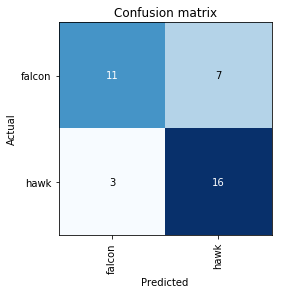

In [95]:
interp.plot_confusion_matrix()

In [96]:
interp.most_confused()

[('falcon', 'hawk', 7), ('hawk', 'falcon', 3)]

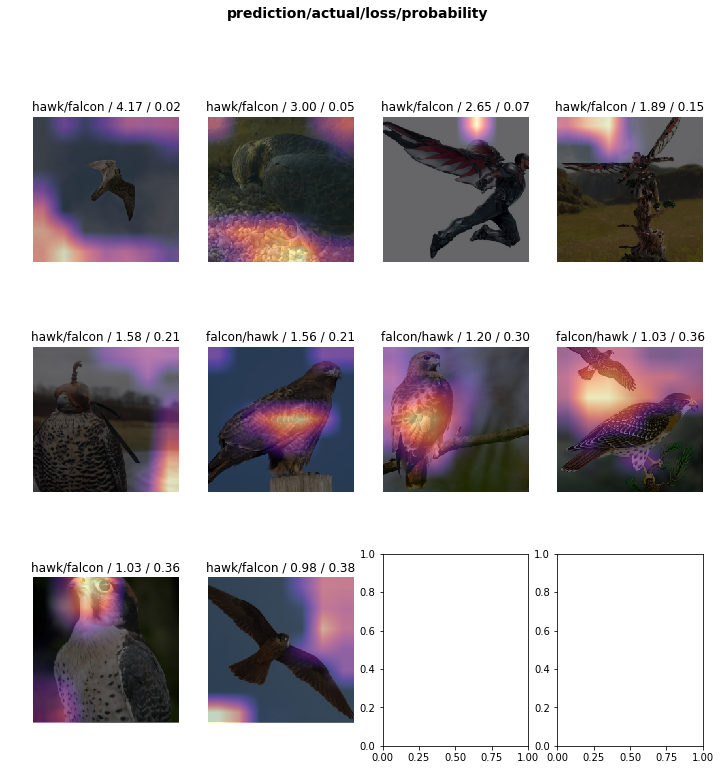

In [98]:
interp.plot_top_losses(10)

### data cleaning

In [99]:
from fastai import widgets

In [103]:
db_toclean = (ImageList.from_folder(datapath)
                             .split_none()
                             .label_from_folder()
                             .transform(get_transforms(), size=224)
                             .databunch())

In [104]:
learner_toclean = cnn_learner(db_toclean, models.resnet34, metrics=error_rate)

In [107]:
learner_toclean.load('chkpt-1');

In [109]:
ds_toclean, idxs_toclean = widgets.DatasetFormatter().from_toplosses(learner_toclean)

In [110]:
widgets.ImageCleaner(ds_toclean, idxs_toclean, datapath)

'No images to show :)'

### check for similars

cleaning saved to a 'cleaned.csv' file; will use that. it can use activations to check for similar images. that's very smart.

In [112]:
db_toclean = (ImageList.from_csv(datapath, 'cleaned.csv', folder='.')
                             .split_none()
                             .label_from_df()
                             .transform(get_transforms(), size=224)
                             .databunch())

In [114]:
learner_toclean = cnn_learner(db_toclean, models.resnet34, metrics=error_rate)
learner_toclean.load('chkpt-1');

In [115]:
ds_toclean, idxs_toclean = widgets.DatasetFormatter().from_similars(learner_toclean)

Getting activations...


Computing similarities...


In [117]:
widgets.ImageCleaner(ds_toclean, idxs_toclean, datapath, duplicates=True)

'No images to show :). 10 pairs were skipped since at least one of the images was deleted by the user.'

## training on cleaned data

In [4]:
np.random.seed(0)
data = ImageDataBunch.from_csv(datapath, folder='.', csv_labels='cleaned.csv',
                               valid_pct=0.2, ds_tfms=get_transforms(), size=224
                              ).normalize(imagenet_stats)

In [7]:
learner = cnn_learner(data, models.resnet34, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


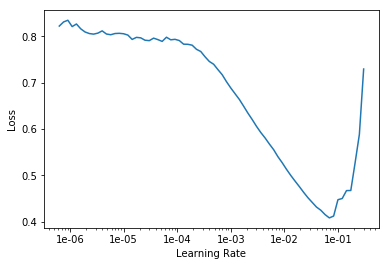

In [8]:
learner.lr_find()
learner.recorder.plot()

In [9]:
learner.fit_one_cycle(5)

the validation loss decreased from 0.597 to 0.517 after cleaning.

In [10]:
learner.save('chkpt-1')

In [11]:
learner.fit_one_cycle(10)

In [12]:
learner.save('chkpt-2')

In [13]:
learner.fit_one_cycle(5, slice(1e-5))

In [14]:
learner.fit_one_cycle(15, slice(1e-5))

very slight overfit, so nah

In [16]:
learner.load('chkpt-2');

doesn't seem to be making much headway like this. it also had the best error rate at the first checkpoint, I'll use that.

### unfreezing layers

training convolutional feature extraction layers

In [17]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


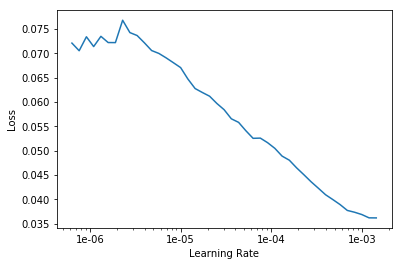

In [18]:
learner.lr_find()
learner.recorder.plot()

In [19]:
lr = 5e-4

In [20]:
learner.fit_one_cycle(5, slice(lr/3, lr))

In [21]:
learner.save('chkpt-stg2')

In [22]:
learner.fit_one_cycle(10, slice(lr/3, lr))

In [23]:
learner.save('chkpt-stg2')

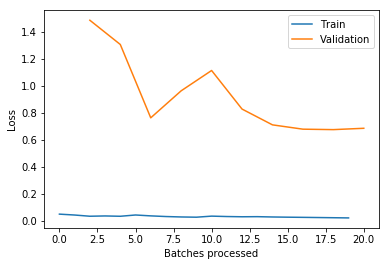

In [24]:
learner.recorder.plot_losses()

In [25]:
learner.fit_one_cycle(10, slice(lr/3, lr))

In [26]:
learner.save('chkpt-stg2')

In [27]:
learner.fit_one_cycle(10, slice(lr/3, lr))

In [28]:
learner.save('chkpt-stg2')

In [29]:
learner.freeze()

Wow. 3/36 wrong. 91.6667% accuracy. Trained on only 147 images for 2 classes, tested on 36. **G'damn**.


In [31]:
data.label_list

LabelLists;

Train: LabelList (147 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
falcon,falcon,falcon,falcon,falcon
Path: /home/jupyter/.fastai/data/raptors;

Valid: LabelList (36 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
hawk,falcon,falcon,hawk,hawk
Path: /home/jupyter/.fastai/data/raptors;

Test: None

In [32]:
interp = ClassificationInterpretation.from_learner(learner)

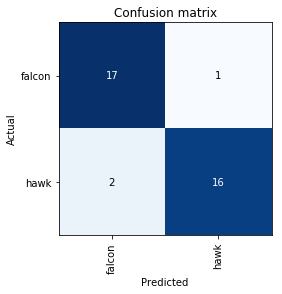

In [33]:
interp.plot_confusion_matrix()

yeah, that's what you want to see.

these are the 9 images the model did the worst on. Only 3 were misclassified.

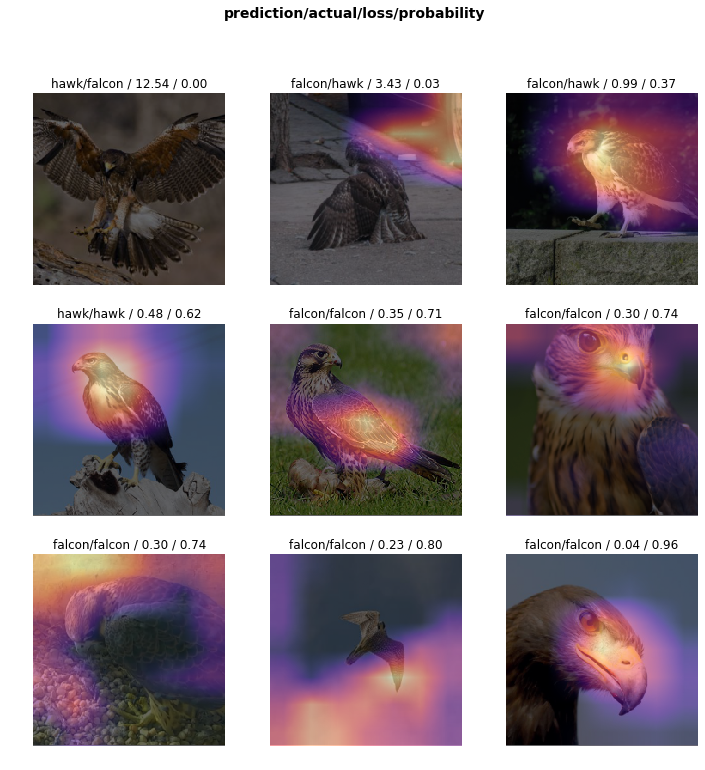

In [36]:
interp.plot_top_losses(9)

## end

---

### appendix

trying to find an image that shouldn't be there, and finally realizing I made a typo waay before:

In [149]:
interp = ClassificationInterpretation.from_learner(learner)

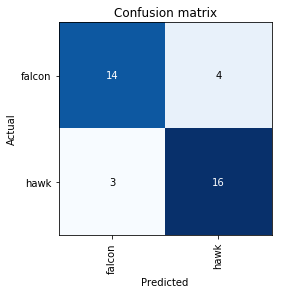

In [150]:
interp.plot_confusion_matrix()

In [151]:
interp.most_confused()

[('falcon', 'hawk', 4), ('hawk', 'falcon', 3)]

trying to find an image that shouldn't be there

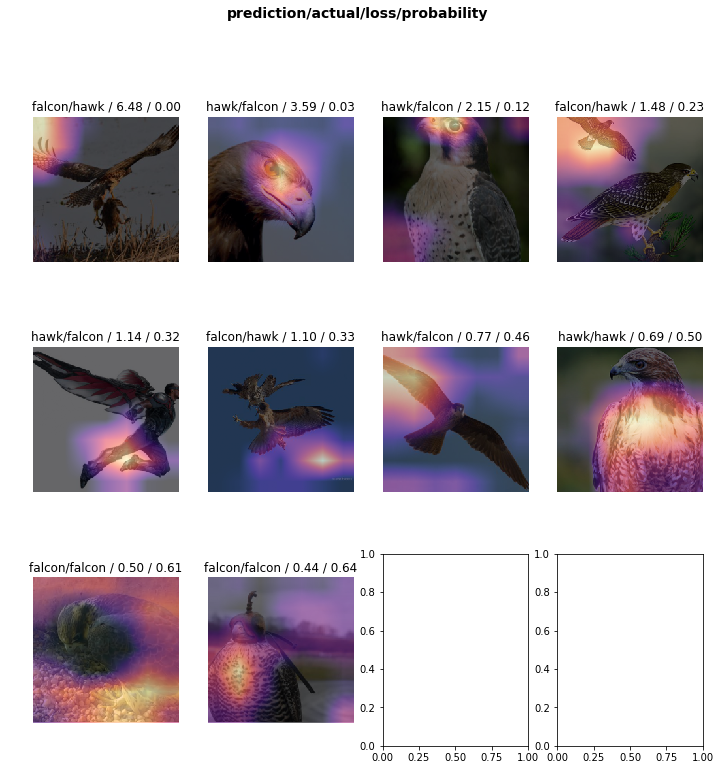

In [166]:
interp.plot_top_losses(10)

In [219]:
fnames = []

with open(datapath/'cleaned.csv') as f:
    for line in f:
        fname = line.split(',')[0]
        fnames.append(fname)

In [251]:
for fname in fnames[1:]:
    fpath = datapath/fname
    folder = fpath.parent
    
    if not (fpath in folder.ls()): print(fpath, folder)

In [253]:
folder = datapath/'falcon'

In [ ]:
op

In [307]:
idx = 0
nimgs = len(folder.ls())

In [384]:
idx -= 2

73/97   /home/jupyter/.fastai/data/raptors/falcon/00000068.jpg


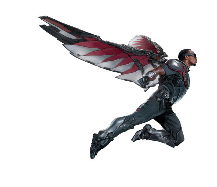

In [385]:
print(f"{idx+1}/{nimgs}   {folder.ls()[idx]}")
show_image(open_image(str((folder).ls()[idx])))
idx = min(idx+1, nimgs-1)
if idx == nimgs-1: print("end of list")

In [390]:
fnames.sort()
fnames[50:70]

['falcon/00000053.jpg',
 'falcon/00000054.jpg',
 'falcon/00000055.jpg',
 'falcon/00000056.jpg',
 'falcon/00000057.jpg',
 'falcon/00000058.jpg',
 'falcon/00000059.jpg',
 'falcon/00000060.jpg',
 'falcon/00000061.jpg',
 'falcon/00000062.jpg',
 'falcon/00000063.jpg',
 'falcon/00000064.jpg',
 'falcon/00000065.jpg',
 'falcon/00000067.jpg',
 'falcon/00000069.jpg',
 'falcon/00000070.jpg',
 'falcon/00000071.JPG',
 'falcon/00000072.jpg',
 'falcon/00000073.jpg',
 'falcon/00000074.jpg']

so, correctly, that image isn't in the cleaned.csv file, but the classification interpreter is still looking at it in the folder. Which raises a bunch of other questions (if its looking at a labeled folder, shouldn't it crash loudly when folders are never used? or at least go haywire?).

Anyway, I'm a bit tired to go through this. If it becomes a problem in the future I will; and a simple failsafe is to just delete images that aren't in the cleaned csv file.

In [391]:
interp.pred_class

tensor([0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1])

In [394]:
learner.get_preds()[1]

tensor([1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1])

oh, the *wrong* learner is being used. But I thought I used the right one? I did. Maybe it's holding onto state from an earlier run?

So if I restart this notebook and reload the learner & data, I *shouldn't* see that picture again.

---

*oh*. **nope**. I mispelled learner as "leaner". Which mean's I've been using the *wrong* learner, actually the original from uncleaned data, *the entire time*.

Well that's annoying. Anyway, lesson learned. I'm not going through the time of doing it all over again. Mostly because this notebook has commentary in it, and it'll 


----ehh fuck it I'll just do it.